# Planning Notebook

In [21]:
import math
import unittest
import numpy as np
from itertools import product
import tqdm
from tqdm import tqdm_notebook
import copy
import pickle

# import gtsam
import gtsam
from gtsam import *
from gtsam.utils.test_case import GtsamTestCase

# import gtbook
import gtbook
from gtbook.display import *
from gtbook.discrete import *

# import local package
import gtsam_planner
from gtsam_planner import *

# import parser
import SASParser
from SASParser import SAS, Operator

variables = Variables()
def pretty(obj): 
    return gtbook.display.pretty(obj, variables)

import graphviz
class show(graphviz.Source):
    """ Display an object with a dot method as a graph."""

    def __init__(self, obj):
        """Construct from object with 'dot' method."""
        # This small class takes an object, calls its dot function, and uses the
        # resulting string to initialize a graphviz.Source instance. This in turn
        # has a _repr_mimebundle_ method, which then renders it in the notebook.
        super().__init__(obj.dot())

In [31]:
class SASToGTSAM():
    def __init__(self, sas):
        self.sas = sas
        self.init = sas.initial_state
        self.goal = sas.goal
        self.vars = self.sas.variables
        self.ops = self.sas.operators
        self.mutex_groups = self.sas.mutex_group
        # self.ops_names = ["null"]
        self.ops_names = []
        for op in self.ops:
            self.ops_names.append(op.name)
    
    def generate_state(self, timestep):
        state = []
        for var, val in self.vars.items():
            state_var = variables.discrete(str(var)+"_"+str(timestep), val)
            state.append(state_var)
        return state
    
    # def generate_operator_key(self, timestep):
    #     op_var = variables.discrete("op_"+str(timestep), self.ops_names)
    #     return op_var
    
    def generate_initial_factor(self, initial_state):
        keys = gtsam.DiscreteKeys()
        for key in initial_state:
            keys.push_back(key)
        init_values = list(self.init.values())
        init_f = gtsam_planner.MultiValueConstraint(keys, init_values)
        return init_f

    def generate_goal_factor(self, goal_state):
        state = list(self.vars.keys())
        keys = gtsam.DiscreteKeys()
        vals = []
        for goal_var, goal_val in self.goal.items():
            keys.push_back(goal_state[state.index(goal_var)])
            vals.append(goal_val)
        goal_f = gtsam_planner.MultiValueConstraint(keys, vals)
        return goal_f
    
    def generate_op_constraint(self, state_t, state_tp, operator):
        state = list(self.vars.keys())
        keys = gtsam.DiscreteKeys()
        vals = []
        for pre_var, pre_val in operator.precondition.items():
            if pre_val == -1:
                continue
            keys.push_back(state_t[state.index(pre_var)])
            vals.append(pre_val)
        
        for eff_var, eff_val in operator.effect.items():
            if eff_val == -1:
                continue
            keys.push_back(state_tp[state.index(eff_var)])
            vals.append(eff_val)
        
        op_f = gtsam_planner.MultiValueConstraint(keys, vals)
        return op_f
    
    def generate_null_constraint(self, state_t, state_tp):
        """
        true if state_t and state_tp is same
        false otherwise
        """
        keys = gtsam.DiscreteKeys()
        for key in (state_t+state_tp):
            keys.push_back(key)
        null_constraint = gtsam_planner.NullOperatorConstraint(keys)
        return null_constraint        

    def generate_mutex_factor(self, state_t):
        state = list(self.vars.keys())
        mutex_variables = []
        mutex_values = []
        
        for mutex_group in self.mutex_groups:
            var_group = []
            val_group = []
            for var, val in mutex_group:
                state_var = state_t[state.index(var)]
                var_group.append(state_var)
                val_group.append(val)
            mutex_variables.append(var_group)
            mutex_values.append(val_group)
        
        factors = []
        for mutex_var, mutex_val in zip(mutex_variables, mutex_values):
            keys = gtsam.DiscreteKeys()
            for var in mutex_var:
                keys.push_back(var)
            mutex = gtsam_planner.MutexConstraint(keys, mutex_val)
            factors.append(mutex)
        return factors
    
    def generate_op_factor(self, state_t, state_tp, op_key):
        op_consts = []
        for op in self.ops:
            op_const = self.generate_op_constraint(state_t, state_tp, op)
            op_consts.append(op_const)

        keys_set = set()
        for op_const in op_consts:
            keys_list = op_const.discreteKeys()
            keys_set.update(keys_list)

        keys = gtsam.DiscreteKeys()
        for key in keys_set:
            keys.push_back(key)

        op_factor = gtsam_planner.OperatorAddConstraint(op_key, keys, op_consts)
        return op_factor
    
    # def generate_op_factor(self, state_t, state_tp, which_op):
    #     op_consts = []
    #     for op in self.ops:
    #         op_const = self.generate_op_constraint(state_t, state_tp, op)
    #         op_consts.append(op_const)
    #     # keys = gtsam.DiscreteKeys()
    #     # for key in state_t + state_tp:
    #     #     keys.push_back(key)
    #     op_factor = gtsam_planner.OperatorConstraint(op_consts, which_op)
    #     return op_factor

In [32]:
sas = SAS()
sas_dir = "sas/block_example.sas"
sas.read_file(sas_dir)
converter = SASToGTSAM(sas)

In [24]:
class TestSASToGTSAM(GtsamTestCase):
    """Tests for Single Value Constraints"""

    def setUp(self):
        sas = SAS()
        sas_dir = "sas/block_example.sas"
        sas.read_file(sas_dir)
        self.converter = SASToGTSAM(sas)
        self.init_state = self.converter.generate_state(0)
        self.next_state = self.converter.generate_state(1)
        self.op_key = self.converter.generate_operator_key(0)

        input = []
        for _, vars in self.converter.vars.items():
            input.append(list(range(len(vars))))
        # tried this but this crashes the kernel
        # for _, vars in self.converter.vars.items():
        #     input.append(list(range(len(vars))))
        self.prods = list(product(*input))
    
    def createVal(self, states, prod):
        values = gtsam.DiscreteValues()
        for state, val in zip(states, prod):
            values[state[0]] = val
        return values

    def createOperatorVal(self, state1, state2, op):
        state = list(converter.vars.keys())
        values = gtsam.DiscreteValues()
        for var, val in op.precondition.items():
            if val == -1:
                continue
            values[state1[state.index(var)][0]] = val
        for var, val in op.effect.items():
            if val == -1:
                continue
            values[state2[state.index(var)][0]] = val
        return values
    
    def valid(self, prod, mutex_group):
        count = 0
        for var, val in mutex_group:
            if prod[var] == val:
                count += 1
            if count > 1:
                return 0.0
        return 1.0

    def test_generateState(self):
        assert len(self.init_state) == 9

    def test_generateOperatorState(self):
        # there are 32 possible operators
        assert self.op_key[1] == 32

    def test_generateInitial(self):
        state = list(converter.vars.keys())
        initial_factor = self.converter.generate_initial_factor(self.init_state)
        total = 0.0
        for prod in self.prods:
            values = self.createVal(self.init_state, prod)
            output = initial_factor(values)
            if output == 1:
                for var, val in self.converter.init.items():
                    assert values[self.init_state[state.index(var)][0]] == val
            total += output
        assert total == 1

    def test_generateGoal(self):
        state = list(converter.vars.keys())
        goal_factor = self.converter.generate_goal_factor(self.next_state)
        total = 0.0
        for prod in self.prods:
            values = self.createVal(self.next_state, prod)
            output = goal_factor(values)
            if output == 1:
                for var, val in self.converter.goal.items():
                    assert values[self.next_state[state.index(var)][0]] == val
            total += output
        assert total > 1

    def test_generateOperatorConstraint(self):
        for operator in converter.ops:
            op_factor = self.converter.generate_op_constraint(self.init_state, self.next_state, operator)
            values = self.createOperatorVal(self.init_state, self.next_state, operator)
            assert op_factor(values) == 1.0
    
    # def test_generateMutex(self):
    #     mutex_factors = self.converter.generate_mutex_factor(self.init_state)
    #     for prod in tqdm_notebook(self.prods, desc='possible states'):
    #         for mutex_factor, mutex_group in zip(mutex_factors, converter.mutex_groups):
    #             check_valid = self.valid(prod, mutex_group)
    #             values = self.createVal(self.init_state, prod)
    #             factor_valid = mutex_factor(values)
    #             tree_factor = mutex_factor.toDecisionTreeFactor()
    #             tree_valid = tree_factor(values)
    #             assert tree_valid == factor_valid == check_valid

    # def test_generateOperatorFactor(self):
        

In [25]:
# unittest.main(argv=[''], verbosity=2, exit=False)

In [26]:
# state_t = converter.generate_state(0)
# op_t = converter.generate_operator(0)
# state_tp = converter.generate_state(0)

In [27]:
# def plan(k):
#     states = []
#     operators = []
#     mutex_factors = []
#     op_factors = []
#     for i in range(k):
#         # generate state
#         state_t = converter.generate_state(i)
#         # generate mutex factor for the state
#         mutex_factor = converter.generate_mutex_factor(state_t)
#         mutex_factors.append(mutex_factor)
#         # generate binary key indicating if operator satisfies all preconditions and effects
#         operators_t = converter.generate_operator(i)
#         states.append(state_t)
#         operators.append(operators_t)
#     last_state = converter.generate_state(k)
#     mutex_factor = converter.generate_mutex_factor(last_state)
#     mutex_factors.append(mutex_factor)
#     states.append(last_state)

#     for j in range(len(states)-1):
#         op_group = []
#         for op_t, op in zip(operators[j], converter.ops):
#             op_factor = converter.generate_op_factor(states[j], states[j+1], op_t, op)
#             op_group.append(op_factor)
#         op_factor = OrConstraint(op_group)
#         op_factors.append(op_factor)

#     initial_factor = converter.generate_initial_factor()
#     goal_factor = converter.generate_goal_factor(states[-1])
#     return states, initial_factor,  goal_factor, mutex_factors, op_factors

In [28]:
# states, initial_factor,  goal_factor, mutex_factors, op_factors = plan(7)

In [9]:
init_state = converter.generate_state(0)
init_factor = converter.generate_initial_factor(init_state)
mutex_factors0 = converter.generate_mutex_factor(init_state)

In [19]:
init_state

[(0, 5), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 5), (7, 5), (8, 5)]

In [10]:
def setup():
    graph = gtsam.DiscreteFactorGraph()   
    graph.push_back(init_factor)
    # for mutex_factor in mutex_factors0:
    #     graph.push_back(mutex_factor)
    return graph

In [11]:
second_state = converter.generate_state(1)
mutex_factors1 = converter.generate_mutex_factor(second_state)

In [12]:
op_factors = []
for i in range(len(converter.ops)):
    op_factor = converter.generate_op_factor(init_state, second_state, i)
    op_factors.append(op_factor)

In [13]:
graph = setup()
vals = graph.optimize()

In [14]:
valid_ops = []
for op in op_factors:
    if op(vals) == 1.0:
        valid_ops.append(op)

In [15]:
valid_ops

[OperatorConstraint on 1 5 0 10 14 9 ,
 OperatorConstraint on 2 5 6 11 14 15 ,
 OperatorConstraint on 3 5 7 12 14 16 ,
 OperatorConstraint on 4 5 8 13 14 17 ]

In [16]:
valid_graphs = []
for val_op in valid_ops:
    graph = setup()
    graph.push_back(val_op)
    valid_graphs.append(graph)
    del graph

In [17]:
val_list = []
for graph in valid_graphs:
    vals = graph.optimize()
    val_list.append(vals)

In [18]:
val_list

[DiscreteValues{0: 4, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 4, 7: 4, 8: 4, 9: 0, 10: 1, 14: 1},
 DiscreteValues{0: 4, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 4, 7: 4, 8: 4, 11: 1, 14: 1, 15: 0},
 DiscreteValues{0: 4, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 4, 7: 4, 8: 4, 12: 1, 14: 1, 16: 0},
 DiscreteValues{0: 4, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 4, 7: 4, 8: 4, 13: 1, 14: 1, 17: 0}]

In [23]:
third_state = converter.generate_state(2)
# mutex_factors2 = converter.generate_mutex_factor(third_state)
op_factors1 = []
for i in range(len(converter.ops)):
    op_factor = converter.generate_op_factor(second_state, third_state, i)
    op_factors1.append(op_factor)

In [ ]:
valid_ops = []
for op in op_factors:
    if op(vals) == 1.0:
        valid_ops.append(op)

In [13]:
valid_ops = []
valid_graphs = []
for op_f in op_factors:
    graph = setup()
    graph.push_back(op_f)
    # for mutex_factor in mutex_factors1:
    #     graph.push_back(mutex_factor)
    vals = graph.optimize()
    if graph(vals) == 1.0:
        valid_ops.append(op_f)
        valid_graphs.append(graph)
    del graph

In [14]:
third_state = converter.generate_state(2)
mutex_factors2 = converter.generate_mutex_factor(third_state)
op_factors = []
for i in range(len(converter.ops)):
    op_factor = converter.generate_op_factor(second_state, third_state, i)
    op_factors.append(op_factor)

In [15]:
new = []

In [16]:
g = pickle.dumps(valid_graphs[0])

TypeError: cannot pickle 'gtsam.gtsam.DiscreteFactorGraph' object

TypeError: cannot pickle 'gtsam.gtsam.DiscreteFactorGraph' object

In [294]:
g.push_back(op_factors[0])

In [296]:
new.append(g)

In [297]:
del g

In [300]:
valid_graphs

[
 size: 3
 factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
 factor 1: OperatorConstraint on 1 5 0 10 14 9 
 factor 2: OperatorConstraint on 10 14 9 19 23 18 ,
 
 size: 2
 factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
 factor 1: OperatorConstraint on 2 5 6 11 14 15 ,
 
 size: 2
 factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
 factor 1: OperatorConstraint on 3 5 7 12 14 16 ,
 
 size: 2
 factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
 factor 1: OperatorConstraint on 4 5 8 13 14 17 ]

In [275]:
g

size: 3
factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
factor 1: OperatorConstraint on 1 5 0 10 14 9 
factor 2: OperatorConstraint on 10 14 9 19 23 18

In [276]:
valid_graphs

[
 size: 3
 factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
 factor 1: OperatorConstraint on 1 5 0 10 14 9 
 factor 2: OperatorConstraint on 10 14 9 19 23 18 ,
 
 size: 2
 factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
 factor 1: OperatorConstraint on 2 5 6 11 14 15 ,
 
 size: 2
 factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
 factor 1: OperatorConstraint on 3 5 7 12 14 16 ,
 
 size: 2
 factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
 factor 1: OperatorConstraint on 4 5 8 13 14 17 ]

In [251]:
new_valid_graphs = []
for i in range(len(valid_graphs)):
    for op_f in op_factors:
        graph = valid_graphs[i]
        print(graph)
        graph.push_back(op_f)
        vals = graph.optimize()
        if graph(vals) == 1.0:
            # valid_ops.append(op_f)
            new_valid_graphs.append(graph)
        del graph


size: 2
factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
factor 1: OperatorConstraint on 1 5 0 10 14 9 


size: 3
factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
factor 1: OperatorConstraint on 1 5 0 10 14 9 
factor 2: OperatorConstraint on 10 14 9 19 23 18 


size: 4
factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
factor 1: OperatorConstraint on 1 5 0 10 14 9 
factor 2: OperatorConstraint on 10 14 9 19 23 18 
factor 3: OperatorConstraint on 11 14 15 20 23 24 


size: 5
factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
factor 1: OperatorConstraint on 1 5 0 10 14 9 
factor 2: OperatorConstraint on 10 14 9 19 23 18 
factor 3: OperatorConstraint on 11 14 15 20 23 24 
factor 4: OperatorConstraint on 12 14 16 21 23 25 


size: 6
factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
factor 1: OperatorConstraint on 1 5 0 10 14 9 
factor 2: OperatorConstraint on 10 14 9 19 23 18 
factor 3: OperatorConstraint on 11 14 15 20 23 24 
factor 4: OperatorConstraint on 12 14 16 21 23 

In [198]:
new_valid_graphs

[]

In [122]:
while a:
    print(a.pop())

3
2
1


In [121]:
a

[1, 2, 3]

In [70]:
vals = graph.optimize()

In [73]:
vals

DiscreteValues{0: 4, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 4, 7: 4, 8: 4}

In [76]:
for f in op_factors:
    tree = f.toDecisionTreeFactor()
    print(tree(vals))

Trying to find value for 

ValueError: DecisionTree::operator(): value undefined for a label

14


In [77]:
graph.push_back(op_factors[0])

In [78]:
new_Vals = graph.optimize()

In [82]:
graph.empty()

False

In [83]:
graph

size: 7
factor 0: MultiValueConstraint on 0 1 2 3 4 5 6 7 8 
factor 1: MutexConstraint on 1 0 6 7 8 
factor 2: MutexConstraint on 2 0 6 7 8 
factor 3: MutexConstraint on 3 0 6 7 8 
factor 4: MutexConstraint on 4 0 6 7 8 
factor 5: MutexConstraint on 5 0 6 7 8 
factor 6: OperatorConstraint on 1 5 0 10 14 9

In [29]:
k = 2
states = []
mutex_factors = []
op_factors = []
for i in range(k-1):
    # generate state
    state = converter.generate_state(i)
    state
    states.append(state)
    # generate factorized mutex group for the state
    mutex_group = converter.generate_mutex_factor(state)
    mutex_factors.append(mutex_group)

In [30]:
for j in range(len(states)-1):
    for k in range(len(converter.ops_names)):
        op_factor = converter.generate_op_factor(states[j], states[j+1], k)
        op_factors.append(op_factor)
initial_factor = converter.generate_initial_factor(states[0])
goal_factor = converter.generate_goal_factor(states[-1])

AttributeError: 'gtsam_planner.gtsam_planner.MultiValueConstraint' object has no attribute 'discretekeys'

In [15]:
states

[[(9, 5),
  (10, 2),
  (11, 2),
  (12, 2),
  (13, 2),
  (14, 2),
  (15, 5),
  (16, 5),
  (17, 5)],
 [(18, 5),
  (19, 2),
  (20, 2),
  (21, 2),
  (22, 2),
  (23, 2),
  (24, 5),
  (25, 5),
  (26, 5)]]

In [16]:
converter.mutex_groups

[[[1, 0], [0, 0], [6, 1], [7, 1], [8, 1]],
 [[2, 0], [0, 1], [6, 0], [7, 2], [8, 2]],
 [[3, 0], [0, 2], [6, 2], [7, 0], [8, 3]],
 [[4, 0], [0, 3], [6, 3], [7, 3], [8, 0]],
 [[5, 0], [0, 0], [6, 0], [7, 0], [8, 0]]]

In [17]:
op_f = op_factors[0]

In [18]:
tree = op_f.toDecisionTreeFactor()

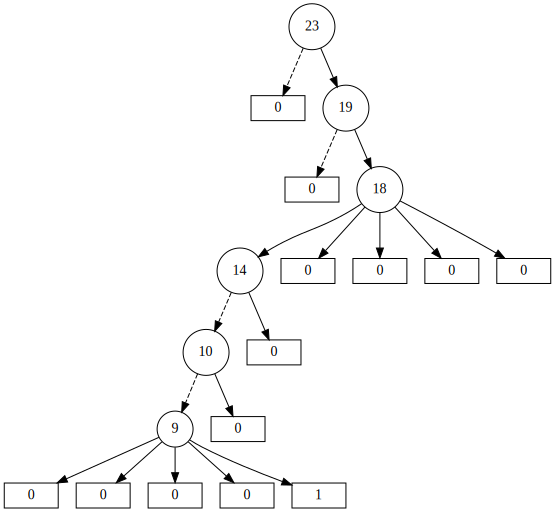

In [19]:
show(tree)

In [20]:
# k = 2
# states = []
# operators = []
# mutex_factors = []
# op_factors = []
# for i in range(k):
#     # generate state
#     state_t = converter.generate_state(i)
#     # generate mutex factor for the state
#     mutex_factor = converter.generate_mutex_factor(state_t)
#     mutex_factors.append(mutex_factor)
#     # generate binary key indicating if operator satisfies all preconditions and effects
#     operators_t = converter.generate_operator(i)
#     states.append(state_t)
#     operators.append(operators_t)
# last_state = converter.generate_state(k)
# mutex_factor = converter.generate_mutex_factor(last_state)
# mutex_factors.append(mutex_factor)
# states.append(last_state)

In [21]:
# for j in range(len(states)-1):
#     op_group = []
#     for op in converter.ops:
#         op_factor = converter.generate_op_factor(states[j], states[j+1], op)
#         op_group.append(op_factor)
#     op_factor = OperatorConstraint(operators[j], op_group)
#     op_factors.append(op_factor)

# initial_factor = converter.generate_initial_factor(states[0])
# goal_factor = converter.generate_goal_factor(states[-1])

In [22]:
# values = gtsam.DiscreteValues()
# values[0] = 4
# values[1] = 0
# values[2] = 0
# values[3] = 0
# values[4] = 0
# values[5] = 0
# values[6] = 4
# values[7] = 4
# values[8] = 4
# #--------------
# values[9] = 4
# values[10] = 0
# values[11] = 1
# values[12] = 0
# values[13] = 0
# values[14] = 1
# values[15] = 0
# values[16] = 4
# values[17] = 4
# #--------------
# values[18] = 1

In [23]:
graph = gtsam.DiscreteFactorGraph()

In [24]:
for m_factor in mutex_factors:
    for f in m_factor:
        graph.push_back(f)

In [25]:
for op_factor in op_factors:
    graph.push_back(op_factor)

In [26]:
graph.push_back(goal_factor)
graph.push_back(initial_factor)

In [27]:
graph.print()


size: 44
factor 0: MutexConstraint on 10 9 15 16 17 
factor 1: MutexConstraint on 11 9 15 16 17 
factor 2: MutexConstraint on 12 9 15 16 17 
factor 3: MutexConstraint on 13 9 15 16 17 
factor 4: MutexConstraint on 14 9 15 16 17 
factor 5: MutexConstraint on 19 18 24 25 26 
factor 6: MutexConstraint on 20 18 24 25 26 
factor 7: MutexConstraint on 21 18 24 25 26 
factor 8: MutexConstraint on 22 18 24 25 26 
factor 9: MutexConstraint on 23 18 24 25 26 
factor 10: OperatorConstraint on 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
factor 11: OperatorConstraint on 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
factor 12: OperatorConstraint on 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
factor 13: OperatorConstraint on 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
factor 14: OperatorConstraint on 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
factor 15: OperatorConstraint on 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
factor 16: OperatorCons